# Visual Transformer (ViT) - MNIST

## Data

In [1]:
import sys
import torch
import torchvision

def write_flush(*text_args, stream=sys.stdout):
    stream.write(', '.join(map(str, text_args)) + '\n')
    stream.flush()
    return

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
write_flush(str(device))

dataset = 'MNIST'

if dataset == 'MNIST':

    tr_img = torchvision.datasets.MNIST('./datasets/', train=True, download=True)
    te_img = torchvision.datasets.MNIST('./datasets/', train=False, download=True)

    nb_channels = 1

else:
    tr_img = torchvision.datasets.CIFAR10('./datasets/', train=True, download=True)
    te_img = torchvision.datasets.CIFAR10('./datasets/', train=False, download=True)

    nb_channels = 3

    tr_img.data = torch.Tensor(tr_img.data).permute((0, 3, 1, 2)).long()
    te_img.data = torch.Tensor(te_img.data).permute((0, 3, 1, 2)).long()

    tr_img.targets = torch.Tensor(tr_img.targets).long()
    te_img.targets = torch.Tensor(te_img.targets).long()

img_size = tr_img.data.shape[-1]
nb_classes = len(tr_img.classes)

cuda


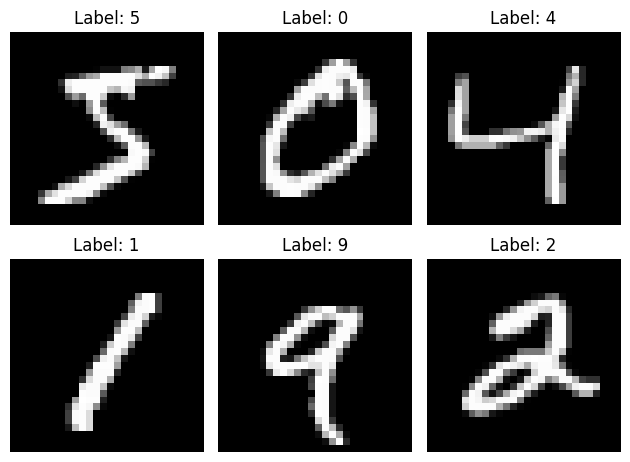

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3)

def vis_img(img):
    if len(img.shape) == 2:
        return img
    return img.permute((1, 2, 0)).squeeze()

for i, ax in enumerate(axes.ravel()):
    ax.imshow(vis_img(tr_img.data[i]), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {tr_img.targets[i]}')

plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


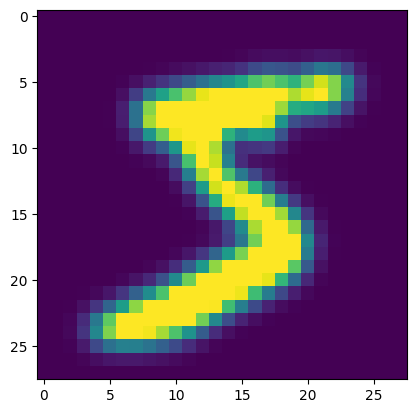

In [3]:
import torchvision.transforms.functional as F

def data_augmentation(img):

    assert -1e-5 < torch.min(img) and torch.max(img) < (1 + 1e-5)

    if len(img.shape) == 2:
        img = img.unsqueeze(0)

    h, w = img.shape[-2:]
    d_h, d_w = torch.randint(3, (1,)), torch.randint(3, (1,))

    img = F.resized_crop(img, d_h, d_w, h - d_h, w - d_w, size=(h, w))

    if torch.randn((1,)) > 0.5:

        img = F.hflip(img)

    img = F.gaussian_blur(img, kernel_size=5, sigma=torch.rand((1,)).item() + 1e-5)

    brightness_factor = 2 ** (-1 + 2 * torch.rand((1,)).item())
    img = F.adjust_brightness(img, brightness_factor)

    contrast_factor = 2 ** (-1 + 2 * torch.rand((1,)).item())
    img = F.adjust_contrast(img, contrast_factor)

    saturation_factor = 2 ** (-1 + 2 * torch.rand((1,)).item())
    img = F.adjust_saturation(img, saturation_factor)

    hue_factor = torch.rand((1,)).item() - 0.5
    img = F.adjust_hue(img, hue_factor)

    return img

img = data_augmentation(tr_img.data[0] / 255.)
plt.imshow(vis_img(img))

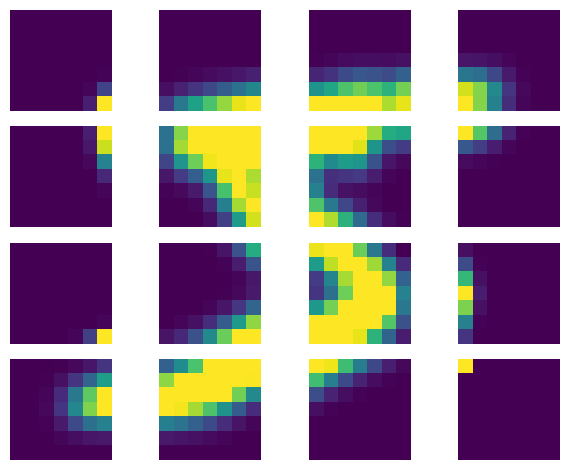

In [4]:
import torch.nn as nn


n_rows, n_cols = 4, 4
d_h, d_w = img_size // n_rows, img_size // n_cols
d_input = nb_channels * d_h * d_w
max_len = n_rows * n_cols


class Patchify(nn.Module):

    def __init__(self, d_h, d_w):

        super(Patchify, self).__init__()

        self.d_h = d_h
        self.d_w = d_w

    def forward(self, x):

        x = x.unfold(2, self.d_h, self.d_h)
        x = x.unfold(3, self.d_w, self.d_w)

        x = x.permute((0, 2, 3, 1, 4, 5))
        x = x.flatten(1, 2).flatten(2, 4)

        return x

patchify = Patchify(d_h, d_w)
patches = patchify(img.unsqueeze(0))

fig, axes = plt.subplots(ncols=n_rows, nrows=n_cols)

for i, ax in enumerate(axes.ravel()):
    patch = patches[0, i].reshape(nb_channels, d_h, d_w)
    ax.imshow(patch.permute((1, 2, 0)))
    ax.axis('off')

plt.tight_layout()

In [5]:
def sample_batch(imgs, labels, nb_batch=128):

    while True:
        # Pytorch randint trick (1000x faster than torch.randperm):
        x = torch.arange(imgs.shape[0])
        idx = x[torch.randint(0, x.shape[0], (nb_batch,))]

        x_batch = imgs[idx] / 255.

        if len(x_batch.shape) == 3:
            x_batch = x_batch.unsqueeze(1)

        #x_batch = torch.stack([data_augmentation(x) for x in x_batch])
        x_batch = 2 * x_batch - 1

        y_batch = labels[idx]

        yield x_batch, y_batch

def iterate_dataset(imgs, labels, nb_batch=128):

    N = imgs.shape[0]

    for i in range(0, N, nb_batch):

        x_batch = imgs[i:i+nb_batch] / 127.5 - 1
        if len(x_batch.shape) == 3:
            x_batch = x_batch.unsqueeze(1)
        y_batch = labels[i:i+nb_batch]

        yield x_batch, y_batch

train_gen = sample_batch(tr_img.data, tr_img.targets)
x_batch, y_batch = next(train_gen)

write_flush(x_batch.shape)
write_flush(y_batch.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


## Model

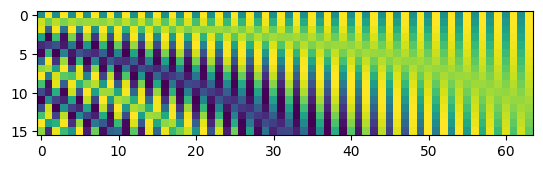

In [6]:
import math

class PositionalEncoding(nn.Module):

    def __init__(self, max_len, d_model, dropout=0.1):

        super(PositionalEncoding, self).__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(max_len) / d_model))
        pe = torch.zeros(1, max_len, d_model)

        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)#[:, :-1]

        self.register_buffer('pe', pe)

    def forward(self, x):

        return x + self.pe[:, :x.shape[1]]

    def visualise(self):
        fig, ax = plt.subplots()
        ax.imshow(self.pe[0])
        plt.show()

pe = PositionalEncoding(max_len=16, d_model=64)
pe.visualise()

In [7]:
from functools import reduce
from torch import nn


def count_params(net):
    nb_params = 0
    for param in net.parameters():
        nb_params += reduce(lambda x, y : x * y, param.shape)
    return nb_params

class Transformer(nn.Module):

    def __init__(
        self,
        d_input: int,
        n_layers: int = 4,
        d_model: int = 256,
        n_head: int = 7,
        d_hidden: int = 256,
        max_len: int = 16,
        p_dropout: float = 0.1,
        nb_classes: int = 10
    ):
        """
        n_layers - number of transformer modules
        d_model  - dimension of token embeddings
        d_head   - number of self-attention heads in each layer
        d_hidden - hidden dimension in self-attention heads (K/Q/V dimension)
        """

        super(Transformer, self).__init__()

        self.d_model = d_model

        self.register_buffer('cls_token', torch.Tensor([[1]]))
        self.cls_encoder = nn.Linear(1, d_model)

        self.patchify = Patchify(d_h, d_w)

        self.encoder = nn.Linear(d_input, d_model)

        self.pos_encoder = PositionalEncoding(max_len=max_len, d_model=d_model)

        encoder_layers = nn.TransformerEncoderLayer(
            d_model, n_head, d_hidden, p_dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_layers)

        self.decoder = nn.Sequential(
            nn.Dropout(p=p_dropout),
            nn.Linear(d_model, d_model),
            nn.ReLU(inplace=True),
            nn.Linear(d_model, nb_classes),
        )

    def forward(self, x, pe=True):

        batch_cls_token = self.cls_token.repeat(x.shape[0], 1)
        batch_cls_token = self.cls_encoder(batch_cls_token).unsqueeze(1)

        x = self.patchify(x)
        x = self.encoder(x)

        if pe:
            x = self.pos_encoder(x)

        x = torch.cat([batch_cls_token, x], axis=1)

        x = self.transformer_encoder(x)
        x = self.decoder(x[:, 0])

        return x

model = Transformer(d_input,
                    d_model=256,
                    n_layers=4,
                    n_head=8,
                    d_hidden=256,
                    p_dropout=0.1).to(device)

print('Number of parameters: %d' % count_params(model))

preds = model(x_batch.to(device))
print(preds.shape)

Number of parameters: 1664778
torch.Size([128, 10])


#### Why do transformers need to a positional encoding in a transformer?

Because otherwise there is no mechanism within a transformer for tokens to learn their sequence position. Recall transformers consist of fully-connected layers and self-attention layers. The fully-connected layers are applied token-wise (equivalent to a 1D convolution with kernel size 1). Self-attention is permutation invariant. Hence, each successive token embedding will be invariant to the sequence position of the token. In other words, without a positional encoding, **any permutation of the input sequence will result in the same outputs**.

Note CNNs do not have this problem because convolutions are typically applied over wider neighbourhoods, giving each pixel an increasing receptive field in which it is context-aware.

Text(0.5, 1.0, 'permuted')

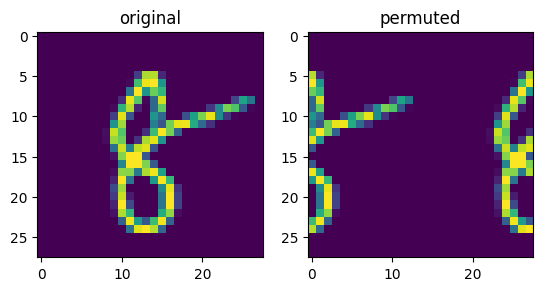

In [8]:
x_sample = x_batch[:1]
x_sample_permuted = torch.cat([x_sample[..., img_size // 2:],
                               x_sample[..., :img_size // 2]], axis=3)

fig, axes = plt.subplots(ncols=2)

axes[0].imshow(vis_img(x_sample.squeeze()))
axes[0].set_title('original')
axes[1].imshow(vis_img(x_sample_permuted.squeeze()))
axes[1].set_title('permuted')

In [9]:
model.eval()

probs = model(x_sample.to(device))
probs_permuted = model(x_sample_permuted.to(device))

print('With positional encoding:')
print(f'Same? {torch.all(torch.abs(probs - probs_permuted) < 1e-5).item()}')

probs = model(x_sample.to(device), pe=False)
probs_permuted = model(x_sample_permuted.to(device), pe=False)

print('Without positional encoding:')
print(f'Same? {torch.all(torch.abs(probs - probs_permuted) < 1e-5).item()}')

With positional encoding:
Same? False
Without positional encoding:
Same? True


## Training

In [10]:
from functools import reduce
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

def count_params(net):
    nb_params = 0
    for param in net.parameters():
        nb_params += reduce(lambda x, y : x * y, param.shape)
    return nb_params

train_gen = sample_batch(tr_img.data, tr_img.targets, nb_batch=1024)

nb_epochs = 20
steps_per_epoch = 100

loss_func = nn.CrossEntropyLoss()
optimiser = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimiser, nb_epochs)

for epoch in range(nb_epochs):

    model.train()
    tr_loss, tr_acc = 0, 0

    for i in range(steps_per_epoch):

        batch = next(train_gen)
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        outputs = model(x_batch)
        loss = loss_func(outputs, y_batch)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        tr_loss += loss.item() / steps_per_epoch

        preds = torch.argmax(outputs, axis=1)
        tr_acc += torch.mean((preds == y_batch).double()) / steps_per_epoch

    scheduler.step()

    model.eval()

    with torch.no_grad():
        losses, preds, targets = [], [], []

        for batch in iterate_dataset(te_img.data, te_img.targets):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            outputs = model(x_batch)

            losses.append(loss_func(outputs, y_batch))
            preds.extend(torch.argmax(outputs, axis=1).detach().cpu())
            targets.extend(y_batch)

        te_loss = torch.mean(torch.Tensor(losses))
        te_acc = torch.mean((torch.Tensor(preds) == torch.Tensor(targets)).double())

    write_flush('[%02d] Tr. Loss: %.04f Te. Loss: %.04f Tr. Acc: %.04f Te. Acc: %.04f' % (
        epoch, tr_loss, te_loss, tr_acc, te_acc))

[00] Tr. Loss: 0.8044 Te. Loss: 0.2155 Tr. Acc: 0.7528 Te. Acc: 0.9351
[01] Tr. Loss: 0.1692 Te. Loss: 0.1262 Tr. Acc: 0.9494 Te. Acc: 0.9601
[02] Tr. Loss: 0.1117 Te. Loss: 0.0941 Tr. Acc: 0.9663 Te. Acc: 0.9710
[03] Tr. Loss: 0.0833 Te. Loss: 0.0781 Tr. Acc: 0.9748 Te. Acc: 0.9756
[04] Tr. Loss: 0.0710 Te. Loss: 0.0760 Tr. Acc: 0.9782 Te. Acc: 0.9757
[05] Tr. Loss: 0.0553 Te. Loss: 0.0751 Tr. Acc: 0.9827 Te. Acc: 0.9770
[06] Tr. Loss: 0.0469 Te. Loss: 0.0606 Tr. Acc: 0.9856 Te. Acc: 0.9825
[07] Tr. Loss: 0.0361 Te. Loss: 0.0631 Tr. Acc: 0.9885 Te. Acc: 0.9814
[08] Tr. Loss: 0.0334 Te. Loss: 0.0628 Tr. Acc: 0.9894 Te. Acc: 0.9823
[09] Tr. Loss: 0.0280 Te. Loss: 0.0592 Tr. Acc: 0.9911 Te. Acc: 0.9832
[10] Tr. Loss: 0.0241 Te. Loss: 0.0614 Tr. Acc: 0.9925 Te. Acc: 0.9839
[11] Tr. Loss: 0.0200 Te. Loss: 0.0598 Tr. Acc: 0.9937 Te. Acc: 0.9835
[12] Tr. Loss: 0.0170 Te. Loss: 0.0575 Tr. Acc: 0.9946 Te. Acc: 0.9850
[13] Tr. Loss: 0.0140 Te. Loss: 0.0597 Tr. Acc: 0.9956 Te. Acc: 0.9840
[14] T

## Attentions

In [11]:
x = next(iterate_dataset(te_img.data, te_img.targets))[0].to(device)

x = model.patchify(x)
x = model.encoder(x)
x = model.pos_encoder(x)

for i in range(4):
    x = model.transformer_encoder.layers[i](x)

_, attn = model.transformer_encoder.layers[3].self_attn(x, x, x)

idx = torch.randint(128, (1,))[0]

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].imshow(te_img.data[idx])
axes[1].imshow(attn[idx].cpu().detach())